In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath(".")))

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

In [3]:
# HYPERPARAMETER
RESULT_DIR = "../run/depthsort_orient/5p_sa_pm_up.msv/"

In [4]:
# PREDS SAVE MOT2D RESULT AS DICT, WITH KEY INDICATING FRAME ID, VALUE INDICATE TRACKED OBJECT (TID, BBOX)
preds = {}
with open(osp.join(RESULT_DIR, 'pred.txt'), 'r') as f:
    lines = [ line for line in f.read().split('\n') if len(line) > 0 ]
    for line in lines:
        fields = [ f for f in line.split(",") if len(f) > 0 ]
        fid = int(fields[0])
        tid = fields[1]
        bbox = np.array([ float(v) for v in fields[2:2+4] ])
        bbox[2] = bbox[0] + bbox[2]
        bbox[3] = bbox[1] + bbox[3]
        if fid not in preds:
            preds[fid] = []
        preds[fid].append((tid, bbox))

In [5]:
# SNAPSHOTS IS A LIST OF SNAPSHOT, A SNAPSHOT RECORDS FEATURE REPRESENTATION ON EACH TRACK
with open(osp.join(RESULT_DIR, 'snapshots_pools.pkl'), 'rb') as f:
    snapshots_pools = pickle.load(f)

In [6]:
# WHICH TRACKS I WANT TO AGGREGATE ALL THE FEATURES
TARGET_TRACKS = [6]

In [7]:
# AGGREGATE TARGET FEATURES TOGETHER
feature_pools = {}

for snapshot_pools in snapshots_pools:
    for tid, pools in snapshot_pools.items():
        if tid in TARGET_TRACKS:
            for k, v in pools.items():
                if k not in feature_pools:
                    feature_pools[k] = []
                feature_pools[k].append(np.array(v).mean(axis=0).reshape(-1))
                
for k in feature_pools.keys():
    feature_pools[k] = np.array(feature_pools[k])

In [8]:
N_SAMPLES = 500

sub_pools = {}
for k, v in feature_pools.items():
    indices = np.random.choice(np.arange(len(v)), N_SAMPLES, replace=False)
    sub_pools[k] = v[indices]
    
all_features = np.concatenate([ features for features in sub_pools.values() ])

In [9]:
all_features.shape

(2000, 128)

In [10]:
# Visualization
pca = PCA(n_components=64)
reduced = pca.fit_transform(all_features)

tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(reduced)

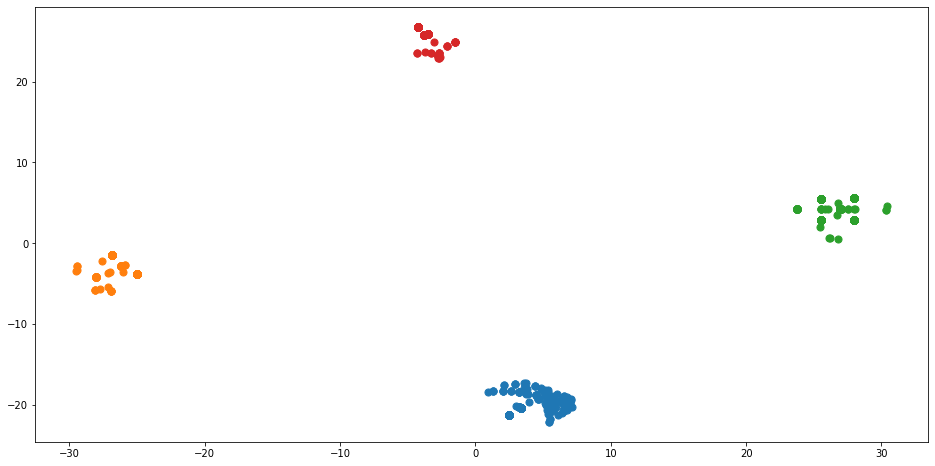

In [11]:
plt.figure(figsize=(16, 8))

for i in range(4):
    start = i*N_SAMPLES
    end = i*N_SAMPLES + N_SAMPLES
    plt.scatter(reduced[start:end, 0], reduced[start:end, 1], s=50)

## Conclusion

From the feature distribution shown above, the feature representatino of a track